 <table style="width:100%">
  <tr>
      <th></th>
      <th><h2><center>Proyecto: Análisis estadístico completo de las precipitaciones pluviales en la ZMG durante los últimos años incluyendo modelación con variables aleatorias discretas y continuas y reflexión sobre la conciencia ecológica.
</center></h2> </th>
    <th><img  title="Logo Tec" src="http://www.gentesinaloa.com/wp-content/uploads/2018/09/TecMonterrey.png" alt="Bosch" width="150" height="50" /></th>
  </tr>
</table>

Datos obtenidos de:

https://smn.cna.gob.mx/es/climatologia/temperaturas-y-lluvias/resumenes-mensuales-de-temperaturas-y-lluvias

https://sinaica.inecc.gob.mx/

In [273]:
from requests import get, post
from pdftables_api import Client
from pandas import read_csv, DataFrame, datetime, concat
from numpy import arange, unique
from re import findall
from bs4 import BeautifulSoup
from ast import literal_eval
import matplotlib.pyplot as plt
api_key = "744xtablcyir"

In [346]:
code = '''
years = arange(1985, 2020)

for year in years:
    ##Guardamos el PDF desde la pagina de gob.mx
    url = "https://smn.cna.gob.mx/tools/DATA/Climatolog%C3%ADa/Pron%C3%B3stico%20clim%C3%A1tico/Temperatura%20y%20Lluvia/PREC/{}.pdf".format(year)
    response = get(url)
    file_name = 'Precipitaciones_{}'.format(year)
    path_pdf = '../Data/PDF/{}.pdf'.format(file_name)
    with open(path_pdf, 'wb') as f:
        f.write(response.content)
    ##Convertimos el PDF a CSV
    path_csv = '../Data/CSV/{}.csv'.format(file_name)
    c = Client(api_key)
    c.csv(path_pdf, path_csv) #replace c.xlsx with c.csv to convert to CSV   
#read_csv(path_csv, header = 2)
'''

In [199]:
stations_names = ["Atemajac","Centro","Las Aguilas", "Las Pintas", "Loma Dorada", "Miravalle", "Oblatos", "Santa Fe", "Tlaquepaque", "Vallarta"]
stations_id = arange(101,111) #Las estaciones de Guadalajara van de la 101 a la 110

In [252]:
url = 'https://sinaica.inecc.gob.mx/pags/datGrafs.php'
#while i, station in enumerate(stations_id):
df = DataFrame(columns=['id','fecha','hora','valor','estacion_id','estacion_nombre'])
for i, station_id in enumerate(stations_id):
    date = "2000-01-01"
    data = []
    while date < "2019-02-18":
        payload = {
            "estacionId": station_id,
            "param": "PP",
            "fechaIni": date,
            "rango": '30',
            "tipoDatos": None
        }
        r = post(url=url,data=payload,headers={'X-Requested-With': 'XMLHttpRequest'})
        s = BeautifulSoup(r.content, 'html.parser')
        script = s.find_all("script",type="text/javascript")[0].text
        #https://stackoverflow.com/questions/24118337/fetch-data-of-variables-inside-script-tag-in-python-or-content-added-from-js
        m = findall('var dat = (.*?);', script)[0]
        m = literal_eval(m)
        if len(m):
            fechas = [x['fecha'] for x in m]
            date = max(fechas)
            for d in m:
                data.append(d)
        else:
            print('empty')
    ids = [x['id'] for x in data]
    fechas = [x['fecha'] for x in data]
    horas = [x['hora'] for x in data]
    valores = [float(x['valor']) for x in data]

    df1 = DataFrame({'id':ids,
                  'fecha':fechas,
                  'hora':horas,
                  'valor':valores,
                  'estacion_id': station_id,
                  'estacion_nombre': stations_names[i]
                    
                 })
    df = concat([df, df1])
df = df.drop_duplicates(subset=['id'], keep=False)    
df.to_csv("../Data/Estaciones/precipitaciones_GDL.csv")

In [355]:
dateparse = lambda dates: [datetime.strptime(d, '%Y-%m-%d') for d in dates]
df = read_csv("../Data/Estaciones/precipitaciones_GDL.csv", index_col=0, parse_dates=['fecha'], date_parser=dateparse)

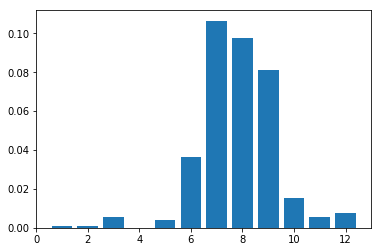

In [382]:
df1 = df.loc[(df.fecha.dt.year == 2017)]
values = df1.groupby(df1.fecha.dt.month).mean().valor.values
plt.bar(arange(1,len(values)+1),values)
plt.show()

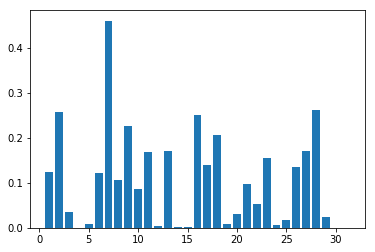

In [384]:
df1 = df.loc[(df.fecha.dt.year == 2017)&(df.fecha.dt.month == 7)]
values = df1.groupby(df1.fecha.dt.day).mean().valor.values
plt.bar(arange(1,len(values)+1),values)
plt.show()

In [398]:
df1 = df1.loc[df1.fecha.dt.day == 7]
(df1.groupby(['hora']).sum() / df1.groupby(['hora']).count()).valor.mean()

0.44702380952380943

In [372]:
file_name = 'Precipitaciones_{}'.format(2001)
path_csv = '../Data/CSV/{}.csv'.format(file_name)

In [351]:
df = read_csv(path_csv, header = 1)
values = df.loc[df.ENTIDAD == 'JALISCO'][df.columns[1:-1]].values[0]

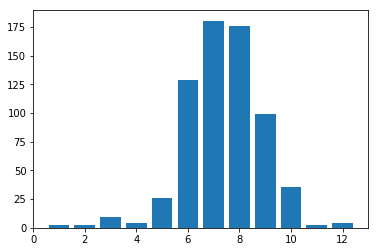

In [352]:
plt.bar(arange(1,13),values)
plt.show()